# Random Forest model

## Učitavanje biblioteka

In [1]:
# Standardne biblioteke
import warnings     
import calendar      
import itertools   
import pickle
from datetime import date   

# Obrada podataka
import pandas as pd
import numpy as np

# Vizuelizacija
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

# Statističke i matematičke funkcije
from scipy import stats
from scipy.stats import gaussian_kde, boxcox
from scipy.special import inv_boxcox
from scipy.signal import periodogram

# Machine learning modeli, metrika i evaluacija
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

# Progres bar za petlje
from tqdm import tqdm

# Lokalni notebook za grafove
%run 00_graphs.ipynb

# Isključenje upozorenja
warnings.filterwarnings('ignore')

c:\Users\lukam\anaconda3\envs\op_env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Učitavanje podataka

In [ ]:
df = pd.read_csv('data\\spatiotemporal_kriging_predictions.csv', parse_dates = ['date'])
location = 'POŽAREVAC'
allergen = 'AMBROZIJA' 
data = df[(df.allergen == allergen) & (df.location == location)]
weather = pd.read_csv('meteo/meteo_df.csv', parse_dates=['date'])
data = pd.merge(left=data, right=weather, how='left', on=['date', 'location'])
end_date = pd.to_datetime('2024-01-01')

## Preprocesiranje

In [3]:
data['transform'] = np.log1p(data['value']/30)
features_cols = []

dates = data['date']
start_md = dates.apply(lambda x: (x.month, x.day)).min()
end_md = dates.apply(lambda x: (x.month, x.day)).max()
min_year = dates.dt.year.min()
max_lags = 5
fourier_order = 0

### Određivanje perioda vremenske serije

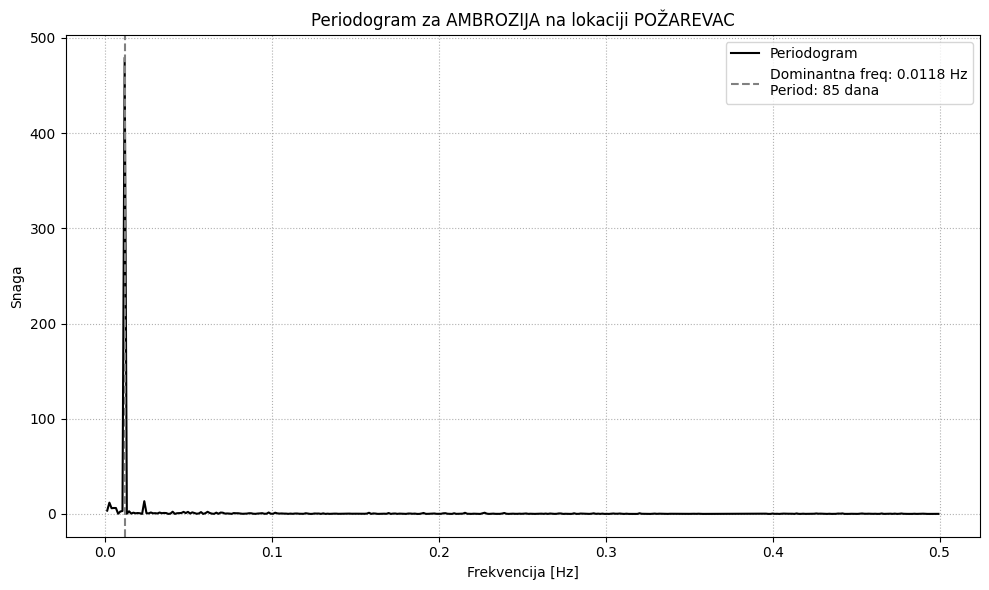

Dominantni period za AMBROZIJA (POŽAREVAC) je: 85 dana


In [30]:
dominant_period = plot_periodogram(data, save=True)

### Dodavanje egzogenih promenljivih

#### Broj dana od početka sezone te godine

In [31]:
data['days_from_start'] = data.apply(lambda row: (row['date'] - pd.Timestamp(year=row['date'].year, month=start_md[0], day=start_md[1])).days, axis=1)
features_cols.append('days_from_start')

#### Godina

In [32]:
data['year'] = data['date'].dt.year
features_cols += ['year']

#### Moving average (7 dana)

In [33]:
def get_rolling_value(data, current_date, window=7):
    """
    Prosečna vrednost za prethodnih 'window' dana.
    """
    # Definisanje početaka i kraja intervala
    start_date = current_date - pd.Timedelta(days=window)
    end_date = current_date - pd.Timedelta(days=1)
    
    # Generisanje liste svih datuma u intervalu
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Mapiranje datum -> vredonst
    window_df = data[data['date'].isin(date_range)]
    value_map = dict(zip(window_df['date'], window_df['transform']))
    values = [value_map.get(date, 0) for date in date_range]
    
    return sum(values) / window

data['rolling_7'] = data.apply(lambda row: get_rolling_value(data, row['date'], window=7), axis=1).fillna(0)
features_cols.append('rolling_7')

#### Isti dan prošle godine

In [34]:
def get_last_year_value(data, current_date):
    """
    Vrednost za isti datum prethodne godine.
    """
    # Ako je trenutna godina jednaka minimalnoj godini, vraća None
    if current_date.year == min_year:
        return None
    
    prev_year_date = current_date - pd.DateOffset(years=1)
    value = data.loc[data['date'] == prev_year_date, 'transform']
    return value.values[0] if not value.empty else None

data['last_year'] = data.apply(lambda row: get_last_year_value(data, row['date']), axis=1)
features_cols.append('last_year')

#### Prozor +/- 3 dana prošle godine

In [35]:
def get_last_year_window(data, current_date, semi_window=3):
    """
    Prosečna vrednost za prozor ±`semi_window` dana oko istog datuma prethodne godine.
    """
    # Ako je trenutna godina jednaka minimalnoj godini, vraća None
    if current_date.year == min_year:
        return None

    prev_year_date = current_date - pd.DateOffset(years=1)
    
    # Generisanje liste datuma u prozoru ±semi_window dana
    date_range = pd.date_range(start=prev_year_date - pd.Timedelta(days=semi_window),
                            end=prev_year_date + pd.Timedelta(days=semi_window))
    
    # Mapiranje datum -> vredonst
    window_df = data[data['date'].isin(date_range)]
    value_map = dict(zip(window_df['date'], window_df['transform']))
    values = [value_map.get(date, 0) for date in date_range]
    
    return sum(values) / len(date_range)

data['last_year_window'] = data.apply(lambda row: get_last_year_window(data, row['date']), axis=1)
features_cols.append('last_year_window')

#### Lagovi

In [36]:
def get_lag_value(data, current_date, lag):
    """
    Vraća vrednost sa određenim vremenskim kašnjenjem u odnosu na zadati datum.
    """
    lag_date = current_date - pd.Timedelta(days=lag)
    value = data.loc[data['date'] == lag_date, 'transform']
    return value.values[0] if not value.empty else 0

for lag in range(1, max_lags + 1):
    col_name = f'lag_{lag}'
    data[col_name] = data.apply(lambda row: get_lag_value(data, row['date'], lag), axis=1).fillna(0)

    features_cols.append(col_name)

#### Dodavanje Furijeovih redova

In [ ]:
def generate_t(dates):
    """
    Generiše linearnu komponentu niza
    """
    dates = pd.to_datetime(dates)
    df = pd.DataFrame({'date': dates})
    min_year = df['date'].dt.year.min()
    max_year = df['date'].dt.year.max()
    all_dates = []
    # Kreiranje kompletanog niza svih datuma u sezonama od min_year do max_year
    for year in range(min_year, max_year + 1):
        start_date =  pd.Timestamp(year=year, month=start_md[0], day=start_md[1])
        end_date = pd.Timestamp(year=year, month=end_md[0], day=end_md[1])
        season_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        all_dates.extend(season_dates.tolist())
    
    # Mapiranje datum -> t
    t_map = {date: idx for idx, date in enumerate(all_dates)}
    t_list = [t_map.get(date, np.nan) for date in df['date']]
    
    return np.array(t_list)

data['t'] = generate_t(data['date'])

def add_fourier_terms(df, col='t', period=dominant_period, K=3):
    for k in range(1, K+1):
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * df[col] / period)
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * df[col] / period)
        features_cols.extend([f'cos_{k}'])
        features_cols.extend([f'sin_{k}'])
    return df

data = add_fourier_terms(data, col='t', period=127, K=fourier_order)

data.dropna(inplace=True)

#### Meteorloski podaci

In [38]:
exog_cols = ['temperature', 'precipitation', 'humidity', 'wind', 'wind_direction']

## GRID search + Rolling Forecast

In [ ]:
def compute_fourier_for_dates(dates, period=dominant_period):
    """
    Generinje Furijeovih redova za listu datuma.
    """
    t = np.array(generate_t(dates))
    dct = {}
    dct = {'date': dates}
    for k in range(1, fourier_order + 1):
        cos_k = np.full_like(t, np.nan, dtype=np.float64)
        sin_k = np.full_like(t, np.nan, dtype=np.float64)
        valid_mask = ~np.isnan(t)

        # Izračunavanje cos i sin komponenti
        cos_k[valid_mask] = np.cos(2 * np.pi * k * t[valid_mask] / period)
        sin_k[valid_mask] = np.sin(2 * np.pi * k * t[valid_mask] / period)

        dct[f'cos_{k}'] = cos_k
        dct[f'sin_{k}'] = sin_k

    return pd.DataFrame(dct)

def generate_forecast_row(forecast_date, last_known, exog_cols):
    """"
    Generisanje jedanog reda feature-a za predikciju datog forecast_date koristeći last_known DataFrame.
    """
    row = {}
    row['date'] = forecast_date

    # Broj dana od početka sezone te godine
    row['days_from_start'] = (forecast_date - pd.Timestamp(year=forecast_date.year, month=start_md[0], day=start_md[1])).days

    # Godina
    row['year'] = forecast_date.year

    # Lagovi
    for lag in range(1, max_lags + 1):
        col_name = f'lag_{lag}'
        lag_date = forecast_date - pd.Timedelta(days=lag)
        value_future = last_known.loc[last_known['date'] == lag_date, 'transform']
        row[col_name] = value_future.values[0] if not value_future.empty else 0

    # Moving average (7 dana)
    start_date_r7 = forecast_date - pd.Timedelta(days=7)
    end_date_r7 = forecast_date - pd.Timedelta(days=1)
    date_range_r7 = pd.date_range(start=start_date_r7, end=end_date_r7)
    window_df = last_known[last_known['date'].isin(date_range_r7)]
    value_map = dict(zip(window_df['date'], window_df['transform']))
    values = [value_map.get(date, 0) for date in date_range_r7]
    row['rolling_7'] = sum(values) / len(values)

    # Isti dan prošle godine
    row['last_year'] = get_last_year_value(data, forecast_date)

    # Prozor +/- 3 dana prošle godine
    row['last_year_window'] = get_last_year_window(data, forecast_date)

    # Furijeovi redovi
    fourier_df = compute_fourier_for_dates([forecast_date])
    row.update(fourier_df.iloc[0].to_dict())

    # Egzogene promenljive
    if exog_cols:
        for ex in exog_cols:
            ex_value = data.loc[data['date'] == forecast_date, ex]
            row[ex] = ex_value.values[0] if not ex_value.empty else None

    return row

def rolling_forecast(data, start_date, end_date, horizon=15, features_cols = None, exog_cols=None, n_estimators=250, 
                 max_depth=None, max_features='sqrt', min_samples_split=5, refit_every = 1):
    """
    Rolling forecast evaluacija modela za dat opseg datuma.
    """
    results = []
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    valid_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    #model_fit = None
    count_since_refit = refit_every

    for current_date in tqdm(valid_dates, desc="Rolling forecast"):
        # Kreiranje trening skupa do trenutnog datuma
        train_df = data[data['date'] < current_date].copy()
        # Generisanje future DataFrame-a za predikciju
        future = pd.date_range(start=current_date, periods=horizon)
        future_df = pd.DataFrame({'date': future})
        future_df = pd.merge(future_df, data, on='date')

        # Inicijalizacija niza za predikcije 
        preds = np.zeros(horizon)
        last_known = train_df.copy()

        if not future_df.empty:
            # Refit modela ako je potrebno
            if count_since_refit >= refit_every or model_fit is None:
                X = last_known[features_cols + exog_cols]
                y = last_known['transform']
                model_fit = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features,
                                                    min_samples_split=min_samples_split, random_state=42, n_jobs=-1).fit(X, y)
                count_since_refit = 0

            for h in range(len(future_df)):
                forecast_date = current_date + pd.Timedelta(days=h)

                # Generisanje feature-e za forecast_date
                row = generate_forecast_row(forecast_date, last_known, exog_cols)
                preds_df = pd.DataFrame([row])

                pred_value = model_fit.predict(preds_df[features_cols + exog_cols])[0]

                pred_value = max(0, pred_value)

                temp_df = pd.DataFrame([{'value': pred_value, 'date': forecast_date, 'transform': pred_value}])
                last_known = pd.concat([last_known, temp_df], ignore_index=True)

                preds[h] = pred_value

        
        actual = data.loc[data['date'] == current_date, 'value']
        actual = actual.iloc[0] if not actual.empty else np.nan

        result_row = {
            "date": current_date,
            "actual": actual,
            "prediction": 30 * np.expm1(preds[0]) if len(preds) > 0 else np.nan
        }
        for i in range(horizon):
            result_row[f"pred{i}d"] = 30 * np.expm1(preds[i])
        results.append(result_row)

        count_since_refit += 1
    return pd.DataFrame(results), model_fit

rolling_df, model_fit = rolling_forecast(data, '2024-07-09', "2024-09-30", horizon=30, features_cols=features_cols, exog_cols=exog_cols)

Rolling forecast: 100%|██████████| 84/84 [05:18<00:00,  3.79s/it]


### Prikaz predikcije za sledeći dan

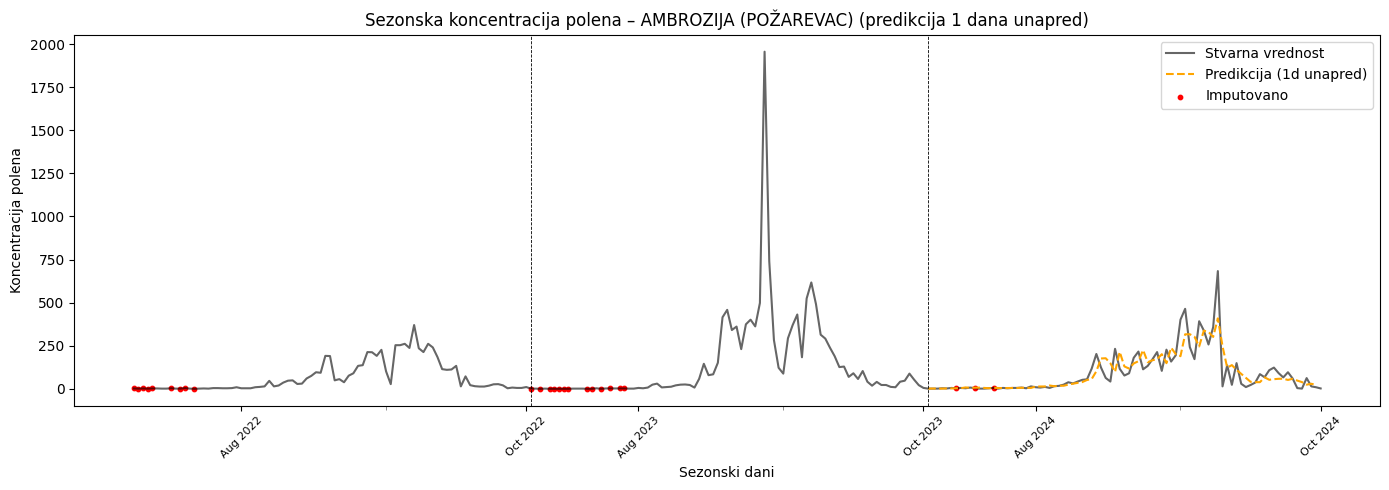

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df,
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=1, 
                          col='value', 
                          save=True)

### Prikaz predikcije za 7. dan unapred

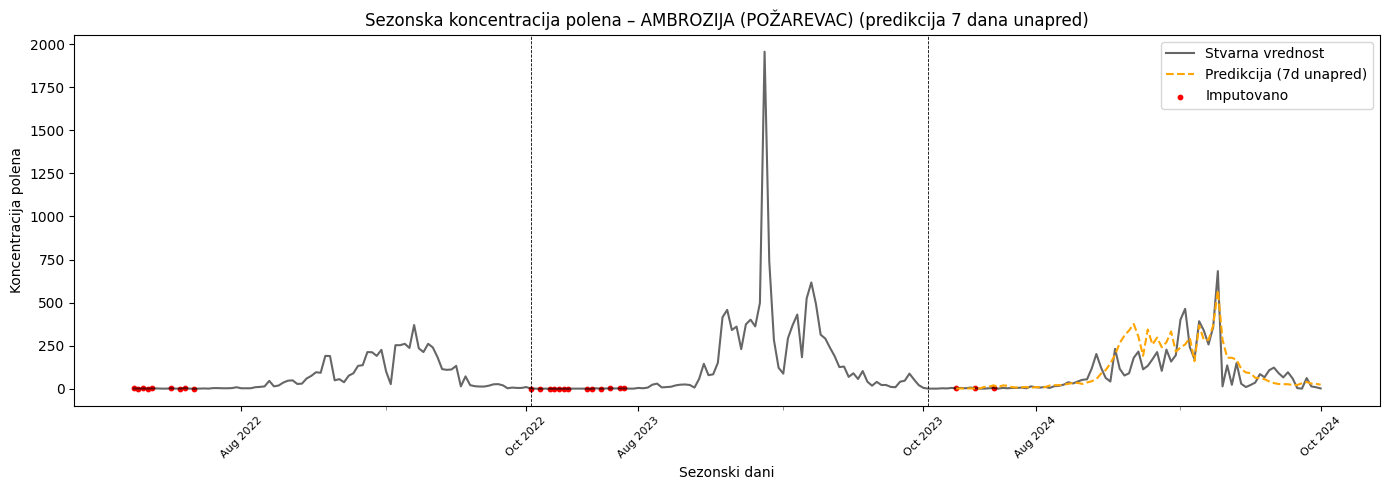

In [ ]:
plot_seasonal_predictions(data = data, 
                          forecast_df = rolling_df,
                          allergen = allergen, 
                          location = location, 
                          n_seasons=3, 
                          n_days=7, 
                          col='value', 
                          save=True)

### Prikaz predikcije 30 dana unapred

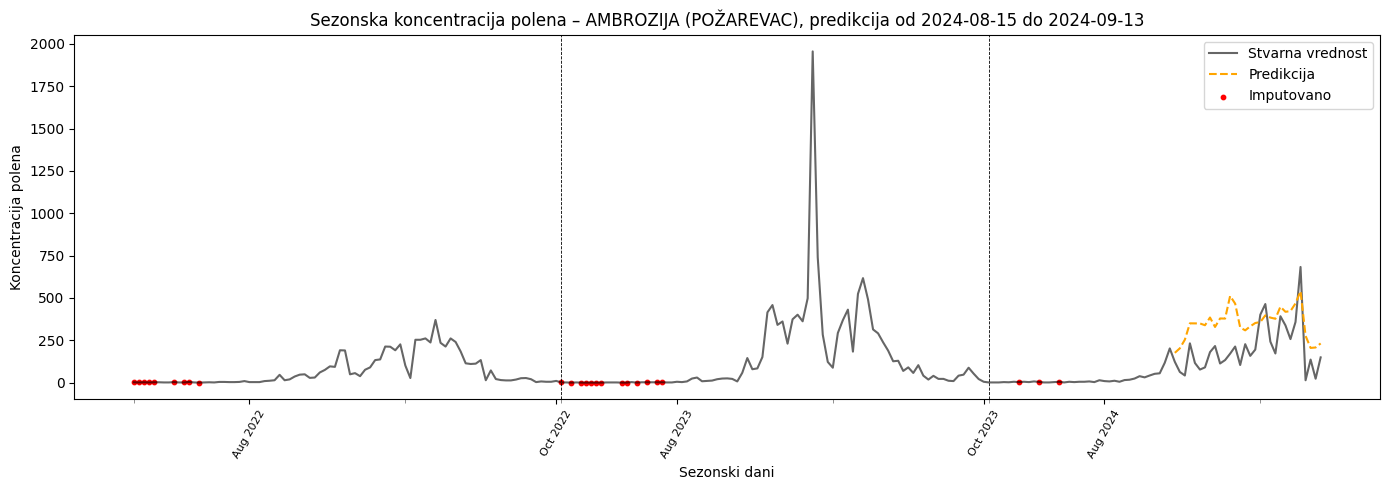

In [48]:
plot_seasonal_predictions_limited(data, rolling_df, '2024-08-15', n_seasons=3, col='value', days_to_predict=30, save=False)

### Prikaz značaja obeležja

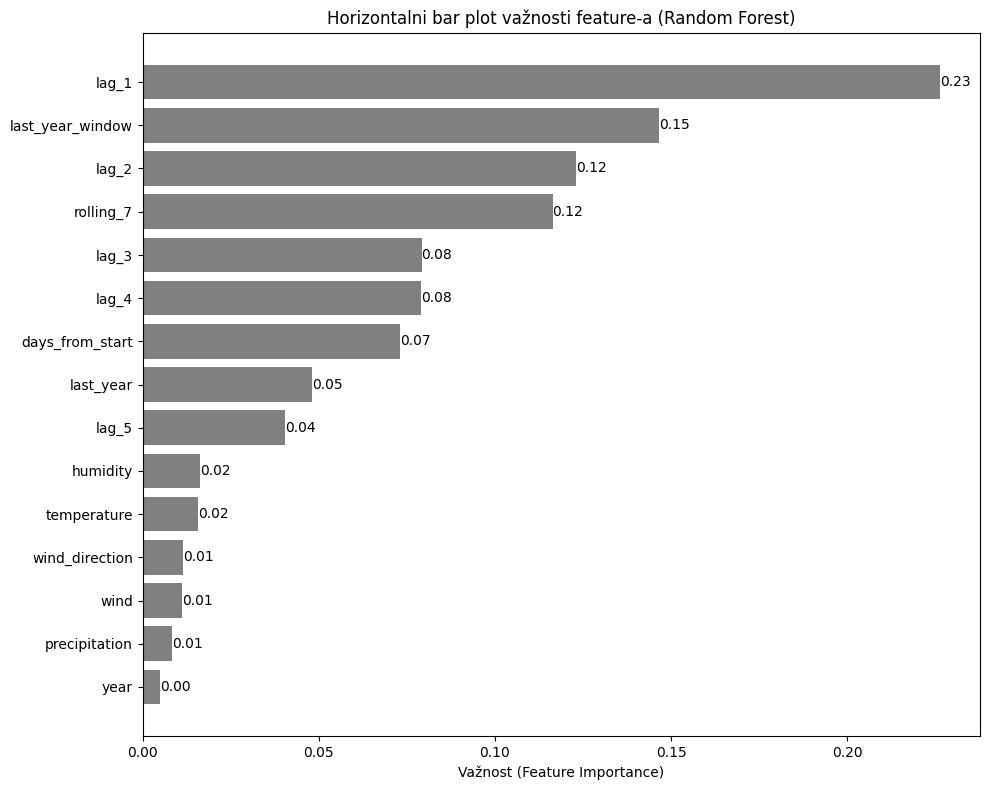

In [ ]:
def plot_feature_importance(model_fit, feature_names):
    """
    Prikaz važnosti svih obeležja.
    """
    # Kreiranje DataFrame-a sa feature-ima i njihovim značajnostima
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model_fit.feature_importances_
    })
    
    # Sortiranje po važnosti
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='gray')
    
    # Dodavanje numeričkih vrednosti na barove
    for bar in bars:
        plt.text(
            bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.2f}',  
            va='center', ha='left', fontsize=10, color='black'
        )
    
    plt.xlabel('Važnost (Feature Importance)')
    plt.title('Horizontalni bar plot važnosti feature-a (Random Forest)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_fit, features_cols + exog_cols)


### Evaluacija modela

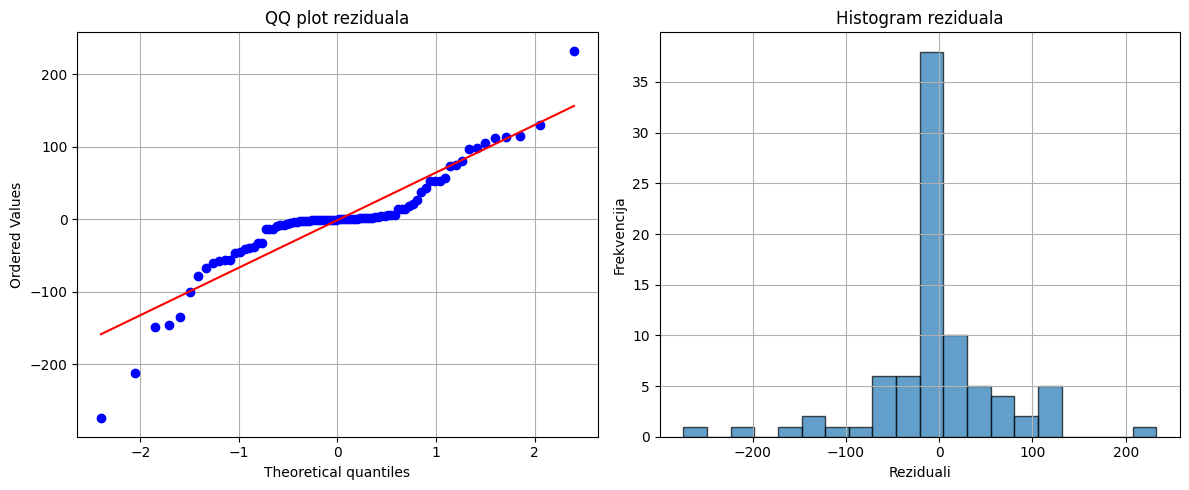


=== Ljung-Box test za autokorelaciju reziduala ===
Statistika: 52.2188
p-vrednost: 0.3878
Broj lagova: 50
=> H0: Nema autokorelacije u rezidualima
Ne odbacuje se H0: nema dokaza o autokorelaciji – reziduali su u redu.


,Vrednost
RMSE,69.178548
MAE,41.076041
RMSLE,0.422287
Bias (mean error),-0.851978
Correlation,0.828463


In [47]:
evaluate_forecast_metrics(rolling_df)

In [4]:
class RandomForestPipeline:
    def __init__(self, transform=None, exog_cols=None, fourier_order=2,  value_col="value", date_col="date"):
        assert transform in ['log', 'boxcox', None], "Transformacija mora biti 'log', 'boxcox' ili None."
        self.transform = transform
        self.exog_cols = exog_cols if exog_cols is not None else []  # meteo promenljive
        self.fourier_order = fourier_order # max Furijeov red
        self.value_col = value_col # naziv kolone za vrednost
        self.date_col = date_col # naziv vremenske kolone
        self.max_lags = 0 # broj maksimalnih kašnjenja u vremenu
        self.rolling_df = None # Evaluacija modela
        self.auto_res = None # Rezultati automatskog podešavanja
        self.fitted_model = None # Fitovani RF model
        self.rolling_dfs = None # Lista rezultata po transformaciji
        self.summary_texts = None # lista Feature Importance po transformaciji
        self.metrics_df = None # Objedinjene metrike performansi
        self.classification_results = None #Klasifikacija polena po nivoima

        self.max_lags=5
        self.n_estimators=100,
        self.max_depth=None
        self.max_features='sqrt'
        self.min_samples_split=2

    def _apply_transform(self, series):
        """
        Transformacija niz.
        """
        if self.transform == 'log':
            transformed = np.log1p(series/30)
            self.lmbda = None
        elif self.transform == 'boxcox':
            safe_val = series + 1e-1
            transformed, self.lmbda = boxcox(safe_val)
        else:  # None
            transformed = series
            self.lmbda = None
        return transformed

    def _inverse_transform(self, series):
        """
        Inverzna transformacija serije.
        """
        if self.transform == 'log':
            return 30 * np.expm1(series)
        elif self.transform == 'boxcox':
            return inv_boxcox(series, self.lmbda) - 1e-1
        return series

    def _get_period(self):
        """
        Detekcija dominantnog perioda u seriji pomoću periodograma.
        """
        # Dominantni period iz periodograma
        frequencies, power = periodogram(self.data['transform'])
        dominant_idx = np.argmax(power[1:]) + 1
        dominant_period = int(np.round(1 / frequencies[dominant_idx]))

        # Očekivani broj dana trajanja sezone
        start = pd.to_datetime(f'2024-{self.start_md[0]:02d}-{self.start_md[1]:02d}', format='%Y-%m-%d')
        end = pd.to_datetime(f'2024-{self.end_md[0]:02d}-{self.end_md[1]:02d}', format='%Y-%m-%d')

        expected_season_days = (end - start).days + 1

        tolerance = 10
        if abs(dominant_period - expected_season_days) > tolerance:
            dominant_period = expected_season_days

        return dominant_period

    def _get_md(self):
        """
        Detekcija početka i kraja sezone.
        """
        min_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).min()
        max_md = self.data[self.date_col].apply(lambda x: (x.month, x.day)).max()
        return min_md, max_md
    
    def _generate_t(self, dates):
        """
        Generinje linearne komponente
        """
        dates = pd.to_datetime(dates)
        df = pd.DataFrame({'date': dates})
        max_year = df['date'].dt.year.max()
        all_dates = []

        # Kreiranje kompletanog niza svih datuma u sezonama od min_year do max_year
        for year in range(self.min_year, max_year + 1):
            start_date =  pd.Timestamp(year=year, month=self.start_md[0], day=self.start_md[1])
            end_date = pd.Timestamp(year=year, month=self.end_md[0], day=self.end_md[1])
            season_dates = pd.date_range(start=start_date, end=end_date, freq='D')
            all_dates.extend(season_dates.tolist())
        
        # Mapiranje datum -> t
        t_map = {date: idx for idx, date in enumerate(all_dates)}
        t_list = [t_map.get(date, np.nan) for date in df['date']]
        
        return np.array(t_list)

    def _add_fourier_terms(self, K):
        """
        Dodavanje K Furijeovih komponenti kao egzogene promenljive.
        """
        self.data['t'] = self._generate_t(self.data[self.date_col])

        for k in range(1, K + 1):
            cname = f'cos_{k}'
            sname = f'sin_{k}'
            valid_mask = self.data['t'].notna()

            # Izračunavanje cos i sin komponenti
            self.data.loc[valid_mask, cname] = np.cos(2 * np.pi * k * self.data.loc[valid_mask, 't'] / self.period)
            self.data.loc[valid_mask, sname] = np.sin(2 * np.pi * k * self.data.loc[valid_mask, 't'] / self.period)

            for name in [cname, sname]:
                if name not in self.features_names:
                    self.features_names.append(name)

    def _check_exog_cols(self, df):
        """
        Provera da li df sadrži sve exog kolone.
        """
        missing_cols = [col for col in self.exog_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Nedostaju egzogene kolone u df: {missing_cols}")
        
    def _compute_fourier_for_dates(self, dates):
        """
        Generinje Furijeovih redova za listu datuma.
        """
        t = np.array(self._generate_t(dates))
        dct = {}
        dct = {self.date_col: dates}
        for k in range(1, self.fourier_order + 1):
            cos_k = np.full_like(t, np.nan, dtype=np.float64)
            sin_k = np.full_like(t, np.nan, dtype=np.float64)
            valid_mask = ~np.isnan(t)

            # Izračunavanje cos i sin komponenti
            cos_k[valid_mask] = np.cos(2 * np.pi * k * t[valid_mask] / self.period)
            sin_k[valid_mask] = np.sin(2 * np.pi * k * t[valid_mask] / self.period)

            dct[f'cos_{k}'] = cos_k
            dct[f'sin_{k}'] = sin_k

        return pd.DataFrame(dct)
        
    def _get_next_valid_dates(self, n_days):
        """
        Vraca sledećih n_days validnih datuma od poslednjeg definisanog datuma.
        """
        last_date = self.data[self.date_col].max()
        found = []
        candidate = last_date + pd.Timedelta(days=1)
        while len(found) < n_days:
            md = (candidate.month, candidate.day)
            if self.start_md <= md < self.end_md:
                found.append(candidate)
            candidate += pd.Timedelta(days=1)
        return found

    def _get_valid_dates(self, start_date, end_date):
        """
        Pronalazi sve datume izmedju start_date i end_date koji su u sezoni.
        """
        all_dates = pd.date_range(start=start_date, end=end_date)
        valid_dates = [d for d in all_dates if self.start_md <= (d.month, d.day) < self.end_md]
        return valid_dates

    def _get_lag_value(self, current_date, lag):
        """
        Vraća vrednost sa određenim vremenskim kašnjenjem u odnosu na zadati datum.
        """
        lag_date = current_date - pd.Timedelta(days=lag)
        value = self.data.loc[self.data[self.date_col] == lag_date, 'transform']
        return value.values[0] if not value.empty else 0

    def _generate_lags(self):
        """
        Generisanje lagova do max_lags
        """
    
        # Brisanje postojećih lagova
        lag_cols = [col for col in self.data.columns if col.startswith('lag_')]
        self.data.drop(columns=lag_cols, inplace=True, errors='ignore')
        self.features_names = [col for col in self.features_names if not col.startswith('lag_')]

        # Generisanje novih lag kolona
        for lag in range(1, self.max_lags + 1):
            col_name = f'lag_{lag}'
            self.data[col_name] = self.data.apply(
                lambda row: self._get_lag_value(row[self.date_col], lag), axis=1
            ).fillna(0)

            self.features_names.append(col_name)

    def _get_rolling_value(self, current_date, window=7):
        """
        Prosečna vrednost za prethodnih 'window' dana.
        """
        # Definisanje početaka i kraja intervala
        start_date = current_date - pd.Timedelta(days=window)
        end_date = current_date - pd.Timedelta(days=1)
        
        # Generisanje liste svih datuma u intervalu
        date_range = pd.date_range(start=start_date, end=end_date)
        
        # Mapiranje datum -> vredonst
        window_df = self.data[self.data[self.date_col].isin(date_range)]
        value_map = dict(zip(window_df[self.date_col], window_df['transform']))
        values = [value_map.get(date, 0) for date in date_range]
        
        return sum(values) / window

    def _get_last_year_value(self, current_date):
        """
        Vrednost za isti datum prethodne godine.
        """
        # Ako je trenutna godina jednaka minimalnoj godini, vraća None
        if current_date.year == self.min_year:
            return None
        
        prev_year_date = current_date - pd.DateOffset(years=1)
        value = self.data.loc[self.data[self.date_col] == prev_year_date, 'transform']
        return value.values[0] if not value.empty else None
    
    def _get_last_year_window(self, current_date, semi_window=3):
        """
        Prosečna vrednost za prozor ±`semi_window` dana oko istog datuma prethodne godine.
        """
        # Ako je trenutna godina jednaka minimalnoj godini, vraća None
        if current_date.year == self.min_year:
            return None

        prev_year_date = current_date - pd.DateOffset(years=1)
        
        # Generisanje liste datuma u prozoru ±semi_window dana
        date_range = pd.date_range(start=prev_year_date - pd.Timedelta(days=semi_window),
                                end=prev_year_date + pd.Timedelta(days=semi_window))
        
        # Mapiranje datum -> vredonst
        window_df = self.data[self.data[self.date_col].isin(date_range)]
        value_map = dict(zip(window_df[self.date_col], window_df['transform']))
        values = [value_map.get(date, 0) for date in date_range]
        
        return sum(values) / len(date_range)

    def _preprocess(self, data):
        """
        Predprocesiranje ulaznog DataFrame-a pre treniranja modela.
        """

        # Provera prisustva svih egzogenih kolona
        self._check_exog_cols(data)

        # Kreiranje kopije ulaznih podataka
        self.data = data.copy()
        
        self.features_names = []

        # Transformacija target kolone
        self.data['transform'] = self._apply_transform(self.data[self.value_col])

        # Detekcija minimalne godine u podacima (za generisanje t)
        self.min_year = self.data[self.date_col].dt.year.min()

        # Detekcija početnog i krajnjeg meseca/dana u sezoni
        self.start_md, self.end_md = self._get_md()

        # Detekcija dominantnog perioda serije pomoću periodograma
        self.period = self._get_period()

        # Generisanje fourier komponenti za sezonske obrasce
        self._add_fourier_terms(self.fourier_order)

        # Broj dana od početka sezone te godine
        self.data['days_from_start'] = self.data.apply(lambda row: (row[self.date_col] - pd.Timestamp(year=row[self.date_col].year, month=self.start_md[0], day=self.start_md[1])).days, axis=1)
        self.features_names.append('days_from_start')

        # Godina     
        self.data['year'] = self.data[self.date_col].dt.year
        self.features_names += ['year']

        # Moving average (7 dana)
        self.data['rolling_7'] = self.data.apply(lambda row: self._get_rolling_value(row[self.date_col], window=7), axis=1).fillna(0)
        self.features_names.append('rolling_7')

        # Isti dan prošle godine
        self.data['last_year'] = self.data.apply(lambda row: self._get_last_year_value(row[self.date_col]), axis=1)
        self.features_names.append('last_year')

        # Prozor +/- 3 dana prošle godine
        self.data['last_year_window'] = self.data.apply(lambda row: self._get_last_year_window(row[self.date_col]), axis=1)
        self.features_names.append('last_year_window')

        # Lagovi 
        self._generate_lags()

        self.data.dropna()

    def _get_lag_value_combined(self, current_date, lag, future_df):
        """
        Vraća vrednost sa određenim vremenskim kašnjenjem u odnosu na zadati datum.
        """
        lag_date = current_date - pd.Timedelta(days=lag)
        value_future = future_df.loc[future_df[self.date_col] == lag_date, 'transform'] if 'transform' in future_df.columns else pd.Series()
        if not value_future.empty:
            return value_future.values[0]
        value_past = self.data.loc[self.data[self.date_col] == lag_date, 'transform']
        return value_past.values[0] if not value_past.empty else 0

    def _get_rolling_value_combined(self, current_date, window=7, future_df=None):
        """
        Prosečna vrednost za prethodnih 'window' dana.
        """
        start_date = current_date - pd.Timedelta(days=window-1)
        past_window = self.data[(self.data[self.date_col] >= start_date) & (self.data[self.date_col] <= current_date)][[self.date_col, 'transform']]
        if future_df is not None and 'transform' in future_df.columns:
            future_window = future_df[(future_df[self.date_col] >= start_date) & (future_df[self.date_col] <= current_date)][[self.date_col, 'transform']]
            combined_window = pd.concat([past_window, future_window]).drop_duplicates(subset=self.date_col).sort_values(self.date_col)
        else:
            combined_window = past_window
        return combined_window['transform'].sum()/window if not combined_window.empty else 0

    def _generate_forecast_row(self, forecast_date, last_known):
        """"
        Generiše jedan red feature-a za predikciju datog forecast_date koristeći last_known DataFrame.
        """
        row = {}
        row[self.date_col] = forecast_date

        # Broj dana od početka sezone te godine
        row['days_from_start'] = (forecast_date - pd.Timestamp(year=forecast_date.year, month=self.start_md[0], day=self.start_md[1])).days

        # Godina
        row['year'] = forecast_date.year

        # Lagovi
        for lag in range(1, self.max_lags + 1):
            col_name = f'lag_{lag}'
            lag_date = forecast_date - pd.Timedelta(days=lag)
            value_future = last_known.loc[last_known[self.date_col] == lag_date, 'transform']
            row[col_name] = value_future.values[0] if not value_future.empty else 0

        # Moving average (7 dana)
        start_date_r7 = forecast_date - pd.Timedelta(days=7)
        end_date_r7 = forecast_date - pd.Timedelta(days=1)
        date_range_r7 = pd.date_range(start=start_date_r7, end=end_date_r7)
        window_df = last_known[last_known[self.date_col].isin(date_range_r7)]
        value_map = dict(zip(window_df[self.date_col], window_df['transform']))
        values = [value_map.get(date, 0) for date in date_range_r7]
        row['rolling_7'] = sum(values) / len(values)

        # Isti dan prošle godine
        row['last_year'] = self._get_last_year_value(forecast_date)

        # Prozor +/- 3 dana prošle godine
        row['last_year_window'] = self._get_last_year_window(forecast_date)

        # Furijeovi redovi
        fourier_df = self._compute_fourier_for_dates([forecast_date])
        row.update(fourier_df.iloc[0].to_dict())

        # Egzogene promenljive
        if self.exog_cols:
            for ex in self.exog_cols:
                ex_value = self.data.loc[self.data[self.date_col] == forecast_date, ex]
                row[ex] = ex_value.values[0] if not ex_value.empty else None

        return row

    def _set_params(self, max_lags=None, n_estimators=None, 
                 max_depth=-1, max_features=None, min_samples_split=None, fourier_order = None):
        """
        Postavljanje hiperparametara Random Forest modela.
        """
        if max_lags: 
            self.max_lags = max_lags
            self._generate_lags()
        if n_estimators: self.n_estimators = n_estimators
        if max_depth!=-1: self.max_depth = max_depth
        if max_features: self.max_features = max_features
        if min_samples_split: self.min_samples_split = min_samples_split
        if fourier_order is not None: self.fourier_order = fourier_order

    def fit(self, df, max_lags=None, n_estimators=None, 
            max_depth=-1, max_features=None, min_samples_split=None, preprocessed = False):
        
        if not preprocessed:
            self._set_params(max_lags, n_estimators, max_depth, max_features, min_samples_split)
            self._preprocess(df)
            X = self.data.dropna()[self.exog_cols + self.features_names]
            y = self.data.dropna()['transform']
        else:
            X = df.dropna()[self.exog_cols + self.features_names]
            y = df.dropna()['transform']

        # Inicijalizacija modela
        model = RandomForestRegressor(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                max_features=self.max_features,
                min_samples_split=self.min_samples_split,
                random_state=42, n_jobs=-1
            )
        self.fitted_model = model.fit(X, y)

    def forecast(self, days=1, exog_df=None):
        """
        Predviđa vrednosti za narednih `days` dana.
        """
        forecast_dates = self._get_next_valid_dates(n_days=days)
        preds = []
        last_known = self.data.copy()

        for forecast_date in forecast_dates:
             # Generisanje feature-e za forecast_date
            row = self._generate_forecast_row(forecast_date, last_known)

            # Dopuni egzogene promenljive iz exog_df
            if self.exog_cols:
                if exog_df is None:
                    raise ValueError("exog_df mora biti prosleđen jer su exog_cols definisane.")
                self._check_exog_cols(exog_df)

                exog_df = exog_df.copy()
                exog_row = exog_df.loc[exog_df[self.date_col] == forecast_date]

                for ex in self.exog_cols:
                    if not exog_row.empty:
                        row[ex] = exog_row.iloc[0][ex]
                    else:
                        row[ex] = None

            # Predikcija
            preds_df = pd.DataFrame([row])
            feature_cols = self.exog_cols + self.features_names
            pred_value = self.fitted_model.predict(preds_df[feature_cols])[0]

            pred_value_orig = self._inverse_transform(pred_value)
            pred_value_orig = max(0, round(pred_value_orig))

            preds.append(pred_value_orig)

            temp_df = pd.DataFrame([{self.date_col: forecast_date, self.value_col: pred_value_orig, 'transform': pred_value}])
            last_known = pd.concat([last_known, temp_df], ignore_index=True)

        # Vraća kao pd.Series sa forecast_dates kao index
        return pd.Series(preds, index=forecast_dates, name='prediction')
    
    def grid_search(self, data, param_grid, start_date, end_date, transforms=0):
        """
        Grid search za optimizaciju Random Forest hiperparametara koristeći rolling forecast.
        Radi kroz više transformacija i uključuje fourier_order.
        """

        if transforms == 0:
            transforms = [self.transform]

        grid = list(ParameterGrid(param_grid))
        self.auto_res = {}                 # Dictionary: {transform: DataFrame sa metrikama}

        data_origin = data.copy()         # Čuvanje originalnih podataka
        best_all = []                     # Lista najboljih rezultata po transformaciji

        for transform in tqdm(transforms, desc="Transformacije"):
            self.transform = transform
            results = []

            for params in tqdm(grid, desc=f"Grid za {transform}", leave=False):

                self._set_params(
                    max_lags=params.get('max_lags', None),
                    n_estimators=params.get('n_estimators', None),
                    max_depth=params.get('max_depth', -1),
                    max_features=params.get('max_features', None),
                    min_samples_split=params.get('min_samples_split', None),
                    fourier_order=params.get('fourier_order', None)
                )

                # Predprocesiranje ulaznih podataka
                self._preprocess(data)

                # Rolling forecast evaluacija
                rolling_df = self.rolling_forecast(start_date=start_date, end_date=end_date, horizon=1)
                true = rolling_df['actual'].values
                pred = rolling_df['prediction'].values

                mask = ~np.isnan(true) & ~np.isnan(pred)
                true = true[mask]
                pred = pred[mask]

                if len(true) == 0:
                    continue

                results.append({
                    'transform': transform,
                    'params': params,
                    'fourier_order': self.fourier_order,
                    'rmse': np.sqrt(np.mean((true - pred) ** 2)),
                    'mae': np.mean(np.abs(true - pred)),
                    'rmsle': np.sqrt(np.mean((np.log1p(true / 30) - np.log1p(pred / 30)) ** 2))
                })

            results_df = pd.DataFrame(results).sort_values('rmse')

            self.auto_res[transform] = results_df

            if not results_df.empty:
                best_result = results_df.iloc[0]
                best_all.append(best_result)

        # Najbolji model preko svih transformacija
        if best_all:
            best_overall = pd.DataFrame(best_all).sort_values('rmse').iloc[0]

            self.transform = best_overall['transform']
            self._set_params(**dict(best_overall['params']))

        # Vraćanje originalnih podataka i ponovni preprocessing
        self.data = data_origin
        self._preprocess(self.data)

        return self.auto_res

    def evaluate_model(self, start_date, end_date, horizon=30, refit_every=15, low=60, high=100):
        """
        Evaluacija najboljih Random Forest modela po transformaciji iz grid_search.
        Radi rolling forecast, računa regresione i klasifikacione metrike.
        """

        if self.auto_res is None or not isinstance(self.auto_res, dict):
            raise ValueError("Nema rezultata iz grid_search(). Pokreni grid_search() pre evaluate_model().")

        data = self.data.copy()

        self.rolling_dfs = {}                
        self.feature_importances = {}      
        self.metrics_dfs = {}        
        classification_results = {}         

        for transform, df in self.auto_res.items():
            if df.empty:
                continue
            
            best_row = df.sort_values("rmsle").iloc[0]

            self.transform = best_row['transform']
            self.fourier_order = best_row.get('fourier_order', None)
            self._set_params(**dict(best_row['params']))
            self._preprocess(data)

            rolling_df = self.rolling_forecast(
                start_date=start_date,
                end_date=end_date,
                horizon=horizon,
                refit_every=refit_every
            )
            
            self.rolling_dfs[transform] = rolling_df
    
            importances = pd.Series(self.fitted_model.feature_importances_, index=self.exog_cols + self.features_names)
            self.feature_importances[transform] = importances.sort_values(ascending=False)

            all_metrics = []
            transform_class_results = {}

            for i in range(horizon):
                col_pred = f"pred{i}d"
                col_actual = f"actual{i}d"
                rolling_df[col_actual] = rolling_df["actual"].shift(-i)

                actual = rolling_df[col_actual]
                pred = rolling_df[col_pred]
                mask = actual.notna() & pred.notna()

                if mask.sum() == 0:
                    continue

                # Regresione metrike
                all_metrics.append({
                    "transform": transform,
                    "forecast_day": i,
                    "MAE": np.mean(np.abs(pred[mask] - actual[mask])),
                    "RMSE": np.sqrt(np.mean((pred[mask] - actual[mask]) ** 2)),
                    "RMSLE": np.sqrt(np.mean((np.log1p(pred[mask] / 30) - np.log1p(actual[mask] / 30)) ** 2))
                })

                # Klasifikacija (low/moderate/high)
                def classify(x):
                    if x < low:
                        return 'low'
                    elif x < high:
                        return 'moderate'
                    else:
                        return 'high'

                actual_cls = actual[mask].apply(classify)
                pred_cls = pred[mask].apply(classify)

                labels = ['low', 'moderate', 'high']
                cm = confusion_matrix(actual_cls, pred_cls, labels=labels)
                report = classification_report(actual_cls, pred_cls, labels=labels, output_dict=True)

                transform_class_results[i] = {
                    "confusion_matrix": cm,
                    "classification_report": report
                }

            self.metrics_dfs[transform] = pd.DataFrame(all_metrics)
            classification_results[transform] = transform_class_results

        self.classification_results = classification_results

        return self.metrics_dfs, self.rolling_dfs, self.feature_importances

    
    def rolling_forecast(self, start_date, end_date, horizon=1, refit_every=15):
        """
        Rolling forecast evaluacija modela za dat opseg datuma.
        """
        results = []
        data = self.data.copy()
        valid_dates = self._get_valid_dates(start_date, end_date)
        model_fit = None
        count_since_refit = refit_every

        for current_date in tqdm(valid_dates, desc="Rolling forecast"):
            # Kreiranje trening skupa do trenutnog datuma
            train_df = data[data[self.date_col] < current_date].copy()
            # Generisanje future DataFrame-a za predikciju
            future = pd.date_range(start=current_date, periods=horizon)
            future_df = pd.DataFrame({self.date_col: future})
            future_df = pd.merge(future_df, data, on=self.date_col)

            # Inicijalizacija niza za predikcije 
            preds = np.zeros(horizon)
            last_known = train_df.copy()

            if not future_df.empty:
                # Refit modela ako je potrebno
                if count_since_refit >= refit_every or model_fit is None:
                    model_fit = self.fit(train_df, preprocessed=True)
                    count_since_refit = 0

                for h in range(len(future_df)):
                    forecast_date = current_date + pd.Timedelta(days=h)

                    # Generisanje feature-e za forecast_date
                    row = self._generate_forecast_row(forecast_date, last_known)
                    preds_df = pd.DataFrame([row])

                    feature_cols = self.exog_cols + self.features_names
                    pred_value = self.fitted_model.predict(preds_df[feature_cols])[0]

                    pred_value_orig = self._inverse_transform(pred_value)
                    pred_value_orig = max(0, round(pred_value_orig))

                    temp_df = pd.DataFrame([{self.value_col: pred_value_orig, self.date_col: forecast_date, 'transform': pred_value}])
                    last_known = pd.concat([last_known, temp_df], ignore_index=True)

                    preds[h] = pred_value_orig

            
            actual = data.loc[data[self.date_col] == current_date, self.value_col]
            actual = actual.iloc[0] if not actual.empty else np.nan

            result_row = {
                "date": current_date,
                "actual": actual,
                "prediction": preds[0] if len(preds) > 0 else np.nan
            }
            for i in range(horizon):
                result_row[f"pred{i}d"] = preds[i]
            results.append(result_row)

            count_since_refit += 1

        self.rolling_df = pd.DataFrame(results)
        return self.rolling_df


# Poredjenje više RF modela

## Najbolji modeli sa i bez meteo podataka, za boxcox, log i bez transoformacije

In [23]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/RF/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/RF/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

In [ ]:
print("Najbolji modeli sa meteo kovarijatama (po RMSLE)")
best_meteo = []
for transform, df in loaded_model_meteo.auto_res.items():
    best_row = df.loc[df["rmsle"].idxmin()]
    best_row["transform"] = transform
    best_meteo.append(best_row)

best_meteo_df = pd.DataFrame(best_meteo)
print(best_meteo_df.to_string(index=False))

print("\nNajbolji modeli bez meteo kovarijata (po RMSLE)")
best_nometeo = []
for transform, df in loaded_model_nometeo.auto_res.items():
    best_row = df.loc[df["rmsle"].idxmin()]
    best_row["transform"] = transform
    best_nometeo.append(best_row)

best_nometeo_df = pd.DataFrame(best_nometeo)
print(best_nometeo_df.to_string(index=False))


Najbolji modeli sa meteo kovarijatama (po RMSLE)
transform                                                                                                                      params  fourier_order       rmse       mae    rmsle
     None {'fourier_order': 3, 'max_depth': None, 'max_features': 'sqrt', 'max_lags': 3, 'min_samples_split': 2, 'n_estimators': 250}              3 188.650092 66.333333 0.358109
   boxcox {'fourier_order': 3, 'max_depth': None, 'max_features': 'sqrt', 'max_lags': 3, 'min_samples_split': 2, 'n_estimators': 250}              3 193.182310 65.428571 0.371395
      log {'fourier_order': 0, 'max_depth': None, 'max_features': 'sqrt', 'max_lags': 3, 'min_samples_split': 2, 'n_estimators': 250}              0 191.301962 64.273810 0.365028

Najbolji modeli bez meteo kovarijata (po RMSLE)
transform                                                                                                                    params  fourier_order      rmse       mae    rmsle
     None 

In [15]:
print("\nNajbolji modeli SA meteo (po RMSLE)")

print("Log:")
print(
    loaded_model_meteo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_meteo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("None:")
print(
    loaded_model_meteo.metrics_dfs[None]
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)


print("\nNajbolji modeli BEZ meteo (po RMSLE)")

print("Log:")
print(
    loaded_model_nometeo.metrics_dfs['log']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("BoxCox:")
print(
    loaded_model_nometeo.metrics_dfs['boxcox']
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)

print("None:")
print(
    loaded_model_nometeo.metrics_dfs[None]
    .nsmallest(1, 'RMSLE')[["RMSLE", "RMSE", "MAE"]]
    .to_string(index=False)
)



Najbolji modeli SA meteo (po RMSLE)
Log:
   RMSLE      RMSE       MAE
0.426523 69.668945 41.833333
BoxCox:
   RMSLE      RMSE       MAE
0.418279 70.099929 42.690476
None:
  RMSLE     RMSE       MAE
0.45657 73.76257 45.440476

Najbolji modeli BEZ meteo (po RMSLE)
Log:
   RMSLE      RMSE       MAE
0.443967 78.992164 44.119048
BoxCox:
  RMSLE      RMSE       MAE
0.43882 77.148743 43.095238
None:
   RMSLE      RMSE       MAE
0.469974 79.647064 46.488095


## RMSLE za naredih 7 dana

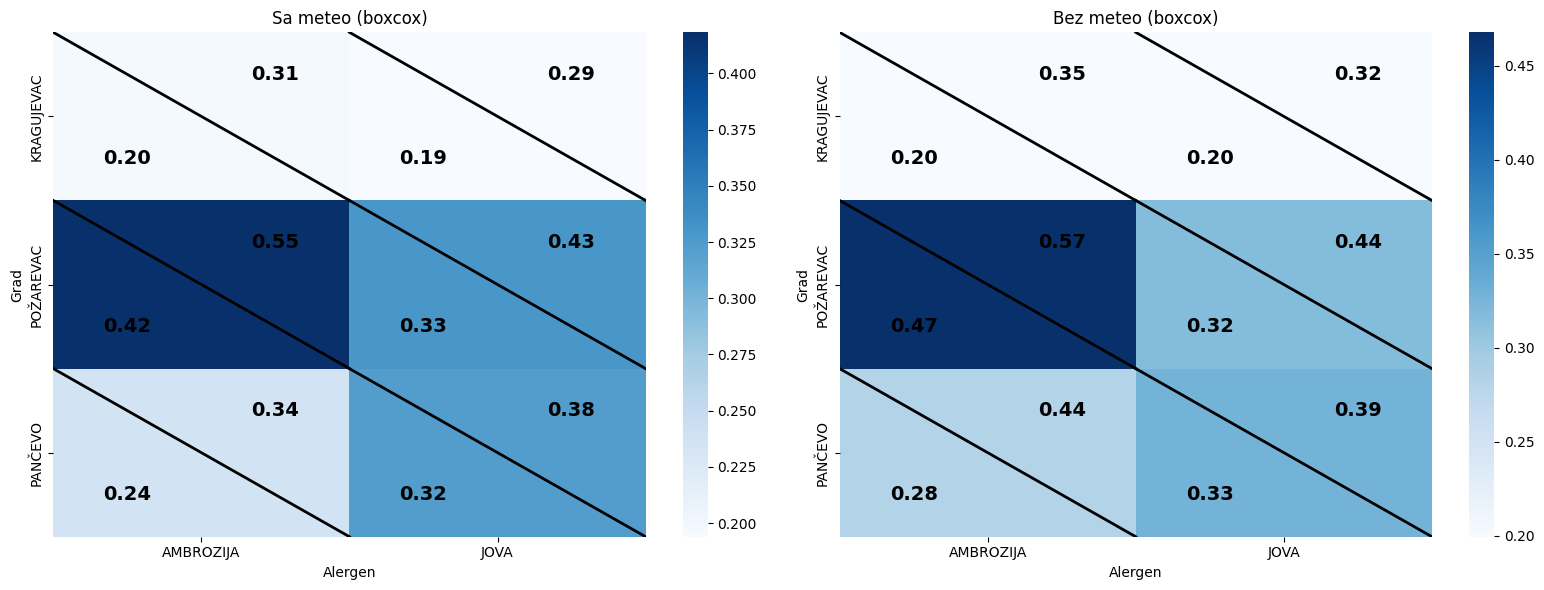

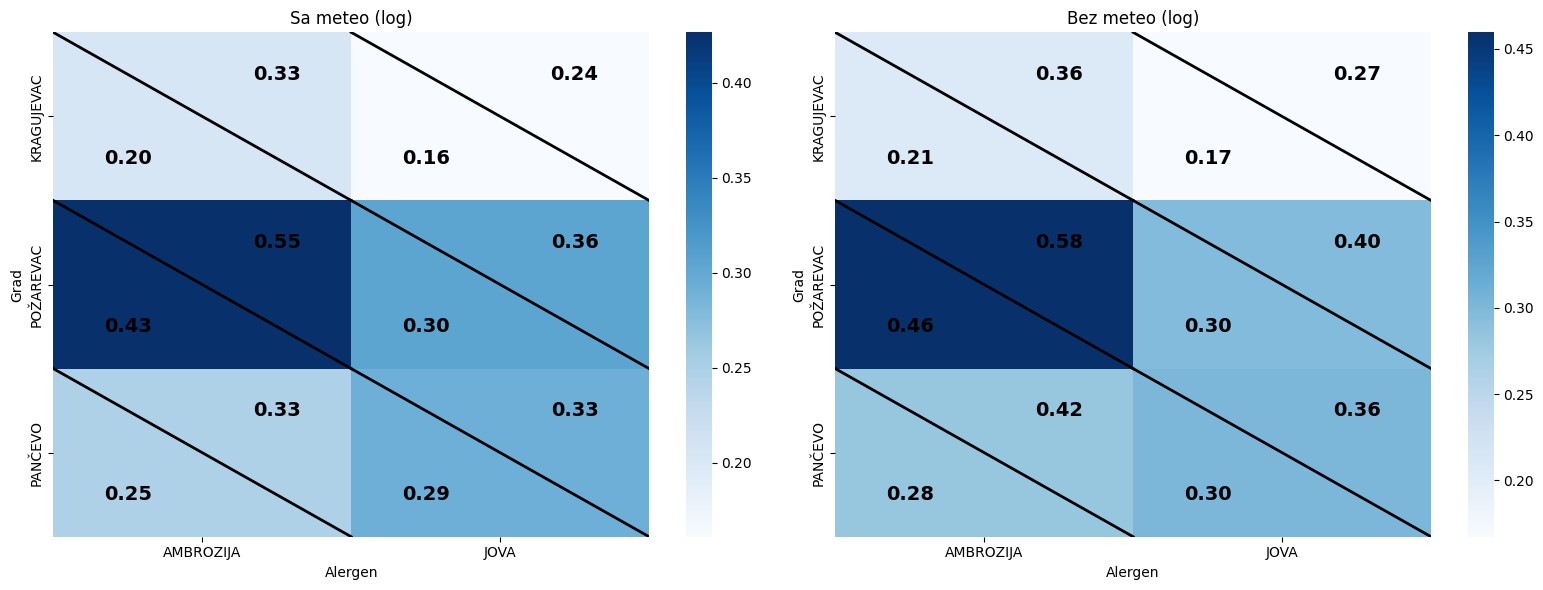

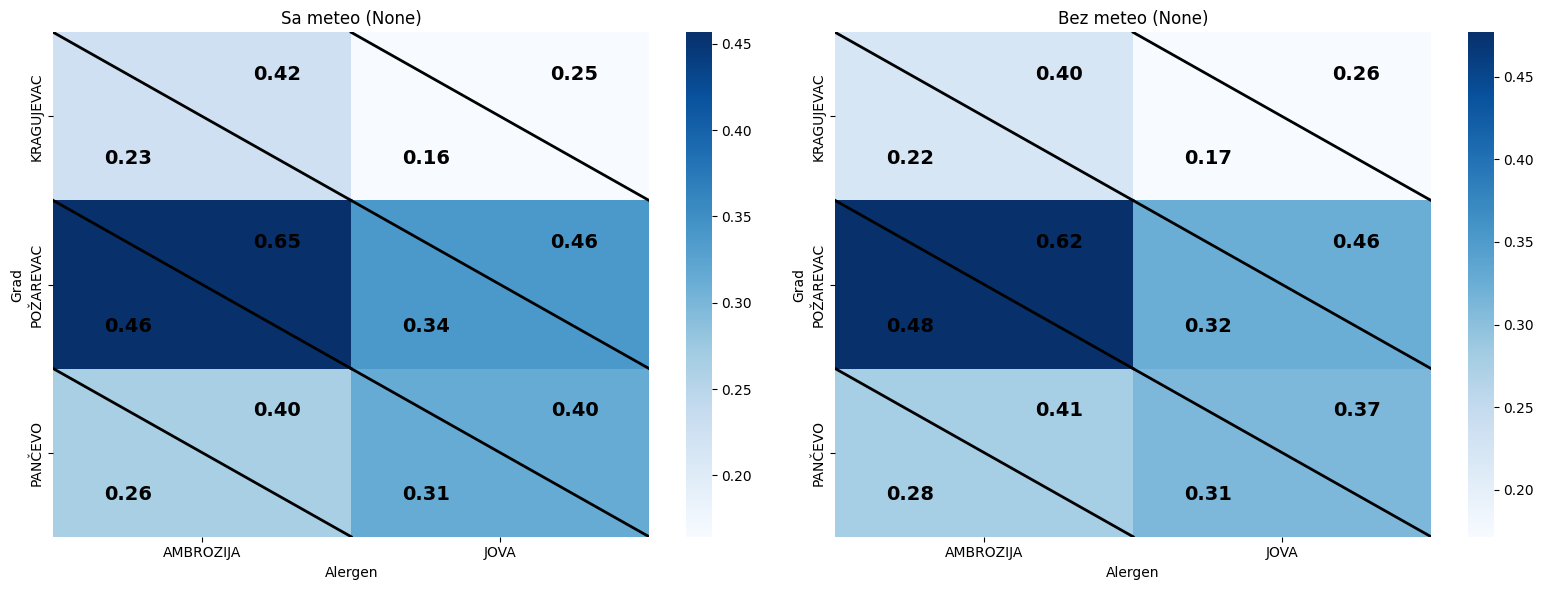

In [18]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA"]

# Funkcija za kreiranje RMSLE DataFrame-a za zadatu transformaciju
def get_rmsle_df_transform(transform_type='log', with_meteo=True):
    rmsle_df_list = []
    for location in locations:
        for allergen in allergens:
            if with_meteo:
                model_path = f"models/RF/{allergen}_{location}.pkl"
            else:
                model_path = f"models/RF/{allergen}_{location}_nometeo.pkl"
            with open(model_path, 'rb') as f:
                loaded_model = pickle.load(f)
            
            if transform_type:
                metrics_df = loaded_model.metrics_dfs[transform_type.lower()]
            else:
                metrics_df = loaded_model.metrics_dfs[None]
            
            rmsle_day_0 = metrics_df[metrics_df['forecast_day'] == 0]['RMSLE'].values[0]
            rmsle_day_6 = metrics_df[metrics_df['forecast_day'] == 6]['RMSLE'].values[0]
            
            rmsle_df_list.append([location, allergen, rmsle_day_0, rmsle_day_6])
    
    return pd.DataFrame(rmsle_df_list, columns=['Grad', 'Alergen', 'RMSLE_Day_0', 'RMSLE_Day_6'])

# Kreiranje DataFrame-ova za obe transformacije i sa/bez meteo
rmsle_df_log_meteo = get_rmsle_df_transform('log', with_meteo=True)
rmsle_df_log_nometeo = get_rmsle_df_transform('log', with_meteo=False)

rmsle_df_bc_meteo = get_rmsle_df_transform('boxcox', with_meteo=True)
rmsle_df_bc_nometeo = get_rmsle_df_transform('boxcox', with_meteo=False)

rmsle_df_none_meteo = get_rmsle_df_transform(None, with_meteo=True)
rmsle_df_none_nometeo = get_rmsle_df_transform(None, with_meteo=False)

def plot_heatmap_two_subplots(rmsle_meteo, rmsle_nometeo, title):
    pivot_meteo = rmsle_meteo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)
    pivot_nometeo = rmsle_nometeo.pivot(index="Grad", columns="Alergen", values="RMSLE_Day_0").reindex(locations)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap sa meteo
    sns.heatmap(pivot_meteo, annot=False, cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Sa meteo ({title})")
    for i, row in enumerate(rmsle_meteo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[0].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[0].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[0].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    # Heatmap bez meteo
    sns.heatmap(pivot_nometeo, annot=False, cmap="Blues", ax=axes[1])
    axes[1].set_title(f"Bez meteo ({title})")
    for i, row in enumerate(rmsle_nometeo.itertuples()):
        row_idx = locations.index(row.Grad)
        col_idx = allergens.index(row.Alergen)
        x, y = col_idx + 0.5, row_idx + 0.5
        axes[1].plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=2)
        axes[1].text(x - 0.25, y + 0.25, f"{row.RMSLE_Day_0:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')
        axes[1].text(x + 0.25, y - 0.25, f"{row.RMSLE_Day_6:.2f}", ha='center', va='center', fontsize=14, color='black', fontweight='bold')

    plt.tight_layout()

plot_heatmap_two_subplots(rmsle_df_bc_meteo, rmsle_df_bc_nometeo, "boxcox")

plot_heatmap_two_subplots(rmsle_df_log_meteo, rmsle_df_log_nometeo, "log")

plot_heatmap_two_subplots(rmsle_df_none_meteo, rmsle_df_none_nometeo, None)


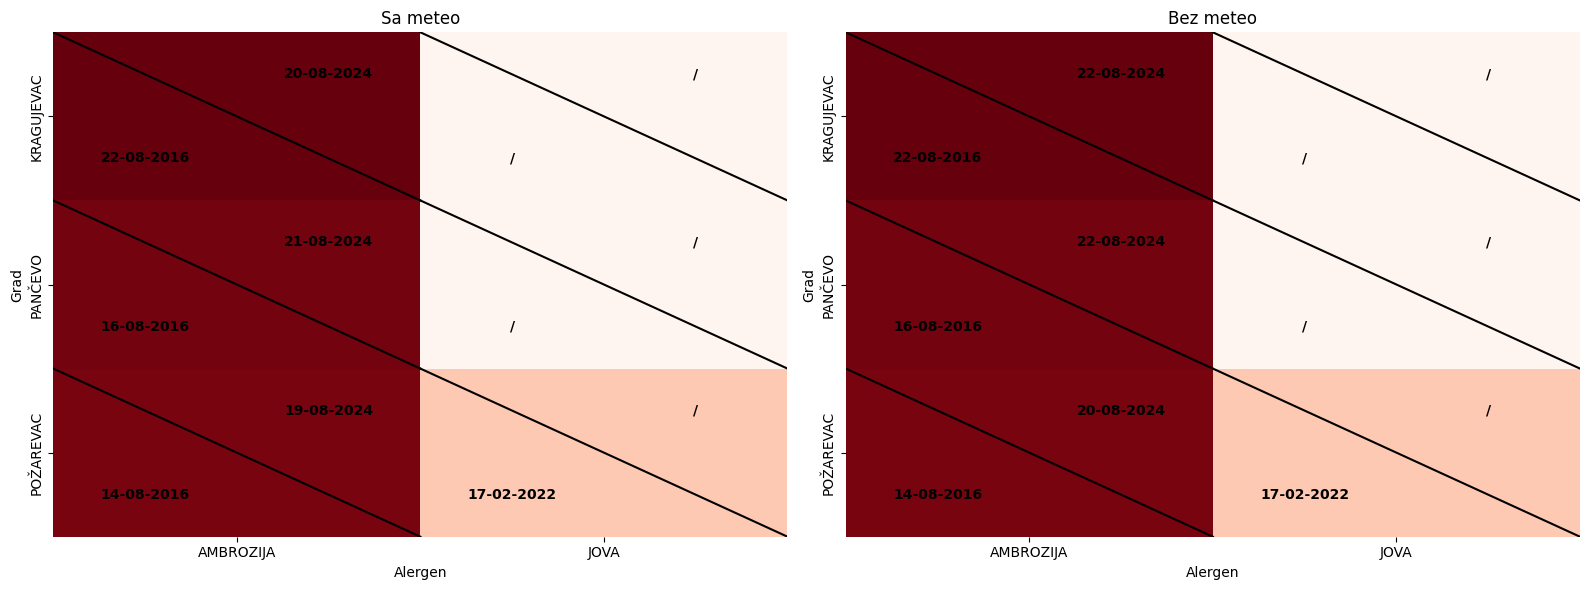

In [19]:
locations = ["KRAGUJEVAC", "POŽAREVAC", "PANČEVO"]
allergens = ["AMBROZIJA", "JOVA"]

thresholds = {
    'AMBROZIJA': 30,
    'JOVA': 60,
    'TRAVE': 60
}

def first_3days_above_threshold(df, allergen, value_col='value', add_days=0):
    df = df.copy()
    threshold = thresholds[allergen]
    df['above_threshold'] = df[value_col] > threshold
    df['three_days'] = df['above_threshold'].rolling(3).sum() == 3
    if df['three_days'].any():
        first_idx = df[df['three_days']].index[0]
        first_date = df.loc[first_idx - 2, 'date']
        return first_date + pd.Timedelta(days=add_days)
    else:
        return pd.NaT
    
def first_3days_above_threshold_pred(df, allergen, add_days=7):
    threshold = thresholds[allergen]
    value_cols = [f'pred{add_days-1}d', f'pred{add_days}d', f'pred{add_days+1}d']
    df['above_threshold'] = df[value_cols].gt(threshold).all(axis=1)
    if df['above_threshold'].any(): 
        first_idx = df[df['above_threshold']].index[0]
        first_date = df.loc[first_idx, 'date']
        return first_date + pd.Timedelta(days=add_days) 
    else:
        return pd.NaT 

def create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True):
    results_list = []
    for location in locations:
        for allergen in allergens:
            key = f"{allergen}_{location}" + ("" if with_meteo else "_nometeo")
            model = loaded_models[key]

            # Stvarna vrednost
            actual_date = first_3days_above_threshold(model.data, allergen, value_col='value', add_days=0)

            # Predikcija forecast_days ranije
            pred_date = first_3days_above_threshold_pred(
                model.rolling_dfs['log'],  # moze i 'boxcox'
                allergen,
                add_days=forecast_days
            )

            results_list.append({
                'Grad': location,
                'Alergen': allergen,
                'Stvarno': actual_date,
                'Predikcija_7d': pred_date + pd.Timedelta(days=6)
            })

    df = pd.DataFrame(results_list)
    df['Stvarno_formatted'] = df['Stvarno'].dt.strftime('%d-%m-%Y')
    df['Predikcija_7d_formatted'] = df['Predikcija_7d'].dt.strftime('%d-%m-%Y')
    return df

def plot_concentration_heatmap_subplots(df_meteo, df_nometeo, title="Ambrozija i Jova"):
    pivot_actual_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_meteo = df_meteo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    pivot_actual_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Stvarno_formatted').fillna("/")
    pivot_pred_nometeo = df_nometeo.pivot(index='Grad', columns='Alergen', values='Predikcija_7d_formatted').fillna("/")

    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # Funkcija za crtanje pojedinačnog heatmap-a sa dijagonalom
    def draw_diagonal_heatmap(ax, pivot_actual, pivot_pred, title_sub):
        color_matrix = pivot_actual.applymap(lambda x: pd.to_datetime(x).dayofyear if x != "/" else 0)
        sns.heatmap(color_matrix, annot=False, cmap="Reds", cbar=False, ax=ax)

        for i, grad in enumerate(pivot_actual.index):
            for j, allergen in enumerate(pivot_actual.columns):
                x, y = j + 0.5, i + 0.5
                ax.plot([x - 0.5, x + 0.5], [y - 0.5, y + 0.5], color='black', lw=1.5)
                ax.text(x - 0.25, y + 0.25, pivot_actual.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')
                ax.text(x + 0.25, y - 0.25, pivot_pred.loc[grad, allergen],
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

        ax.set_title(title_sub)
        ax.set_ylabel("Grad")
        ax.set_xlabel("Alergen")

    draw_diagonal_heatmap(axes[0], pivot_actual_meteo, pivot_pred_meteo, "Sa meteo")

    draw_diagonal_heatmap(axes[1], pivot_actual_nometeo, pivot_pred_nometeo, "Bez meteo")

    plt.tight_layout()
    plt.show()

# Učitavanje modela 
loaded_models = {}
for location in locations:
    for allergen in allergens:
        # Sa meteo
        path_meteo = f"models/RF/{allergen}_{location}.pkl"
        with open(path_meteo, 'rb') as f:
            loaded_models[f"{allergen}_{location}"] = pickle.load(f)

        # Bez meteo
        path_nometeo = f"models/RF/{allergen}_{location}_nometeo.pkl"
        with open(path_nometeo, 'rb') as f:
            loaded_models[f"{allergen}_{location}_nometeo"] = pickle.load(f)

df_dates_meteo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=True)
df_dates_nometeo = create_concentration_dates_df(loaded_models, forecast_days=7, with_meteo=False)

plot_concentration_heatmap_subplots(df_dates_meteo, df_dates_nometeo)

## Rezultati klasifikacije za narednih 7 dana

In [7]:
allergen = 'AMBROZIJA'
location = 'POŽAREVAC'

model_path = f"models/RF/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/RF/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

loaded_model_meteo.classification_results['log'][6]

{'confusion_matrix': array([[26,  3,  4],
        [ 5,  9,  3],
        [ 0,  5, 23]]),
 'classification_report': {'low': {'precision': 0.8387096774193549,
   'recall': 0.7878787878787878,
   'f1-score': 0.8125,
   'support': 33},
  'moderate': {'precision': 0.5294117647058824,
   'recall': 0.5294117647058824,
   'f1-score': 0.5294117647058824,
   'support': 17},
  'high': {'precision': 0.7666666666666667,
   'recall': 0.8214285714285714,
   'f1-score': 0.793103448275862,
   'support': 28},
  'accuracy': 0.7435897435897436,
  'macro avg': {'precision': 0.711596036263968,
   'recall': 0.7129063746710805,
   'f1-score': 0.7116717376605814,
   'support': 78},
  'weighted avg': {'precision': 0.74543700027571,
   'recall': 0.7435897435897436,
   'f1-score': 0.7438384173297966,
   'support': 78}}}

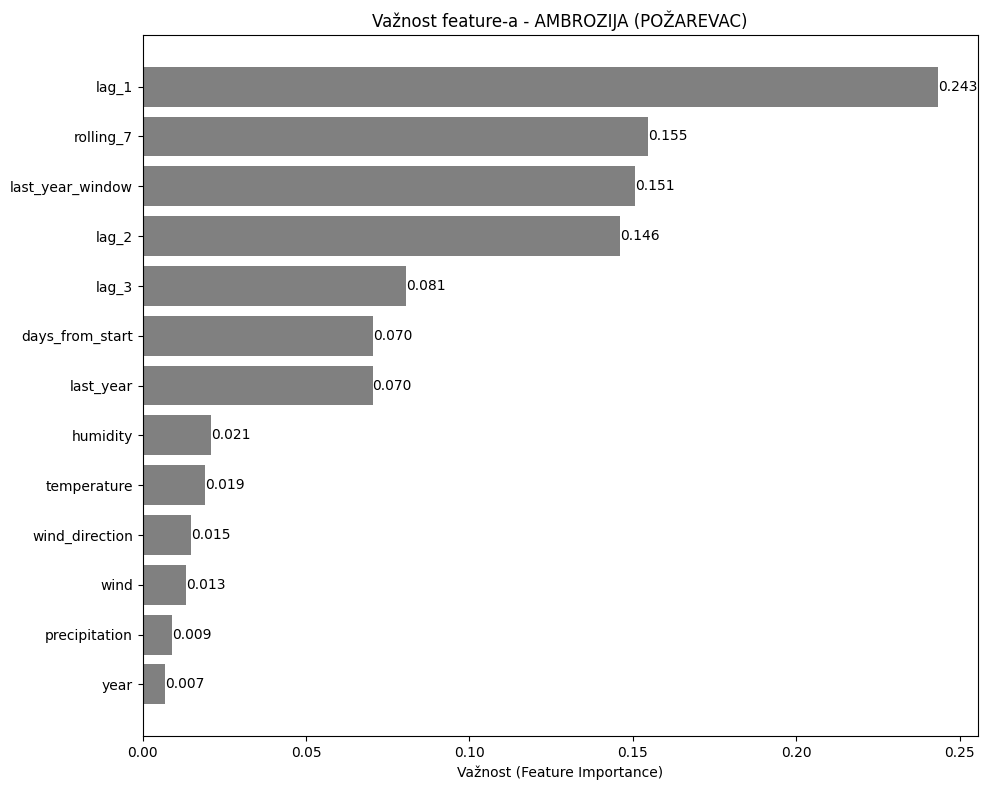

In [8]:
def plot_feature_importance(feature_importance, allergen, location, save = False):
    """
    Prikaz važnosti svih obeležja.
    """
    feature_importance = feature_importance.sort_values(ascending=True)

    plt.figure(figsize=(10, 8))
    bars = plt.barh(feature_importance.index, feature_importance.values, color='gray')

    for bar in bars:
        plt.text(
            bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.3f}',
            va='center', ha='left', fontsize=10, color='black'
        )

    plt.xlabel('Važnost (Feature Importance)')
    plt.title(f'Važnost feature-a - {allergen} ({location})')
    plt.tight_layout()
    if save:
        save_path = f'grafici\\feature_importance_{allergen}_{location}.png'
        plt.savefig(save_path, dpi=75)

plot_feature_importance(loaded_model_meteo.feature_importances['log'], allergen, location, True)

## RMSLE vrednosti po različitim horizontima predikcije

In [20]:
allergen = 'JOVA'
location = 'POŽAREVAC'

model_path = f"models/RF/{allergen}_{location}.pkl"
with open(model_path, 'rb') as f:
    loaded_model_meteo = pickle.load(f)

model_path = f"models/RF/{allergen}_{location}_nometeo.pkl"
with open(model_path, 'rb') as f:
    loaded_model_nometeo = pickle.load(f)

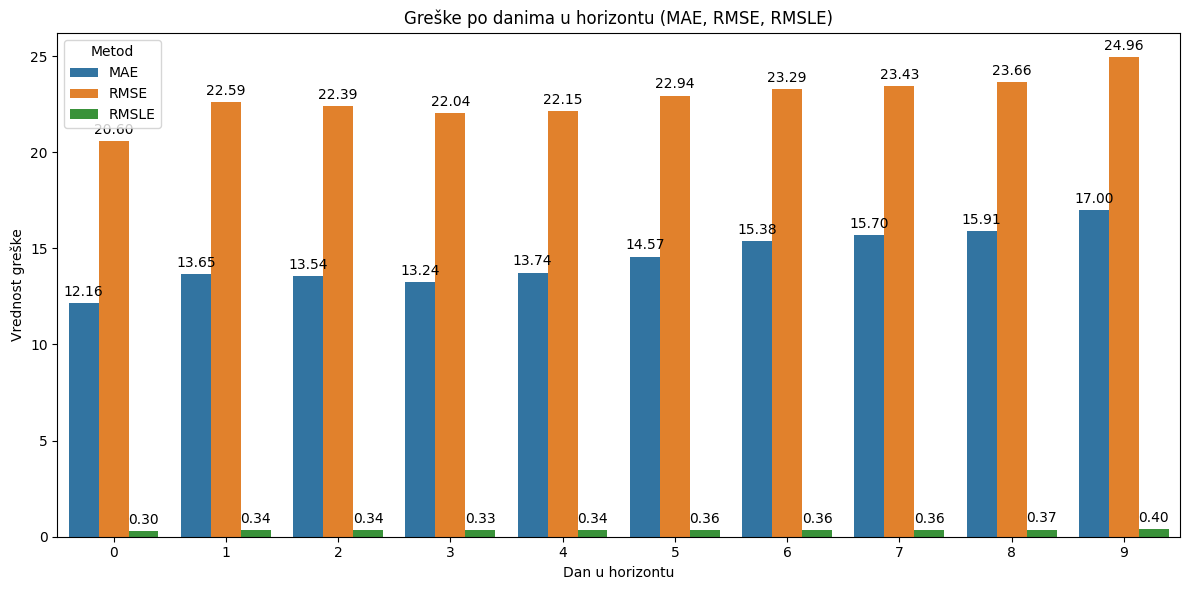

In [21]:
plot_forecast_error_metrics_from_rolling(rolling_df = loaded_model_meteo.rolling_dfs['log'], 
                                             allergen=allergen, 
                                             location=location, 
                                             horizon=10, 
                                             save=False)